In [1]:
from Advertising.learners.greedyLearner import *
import matplotlib.pyplot as plt
import numpy as np
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.GTS_Learner import *
from Advertising.learners.GTS_SW_Learner import *
from Advertising.learners.TS_no_qualities import *
from tqdm.autonotebook import tqdm
from Advertising.learners.TS_sliding_window import *
import itertools
seed = 6789
random.seed(seed)
only_first = False


lambdas = [0.5, 0.42, 0.38, 0.30, 0.2, 0.05]
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')

adversary_bids = []
for _ in range(0, 10):
    adversary_i_bids = []
    for __ in range(0, 5):
        adversary_i_bids.append(random.randint(0, 4))
    adversary_bids.append(adversary_i_bids)


with open("Config/estimated_influence.json", "r"):
    data = json.load(open("Config/estimated_influence.json"))

active_by_influence_reward = np.array(data.get("estimated_influence"))


In [2]:
expected_values = []
expected_values2 = []
sw_size = 5000
arms = arms_creation(seed=30291, number_of_arms=20)
ts_learner = GTS_SW_Learner(20, arms, variance=5, size_SW=sw_size, ad_id=1)
ts_learner2 = GTS_SW_Learner(20, arms, variance=5, size_SW=sw_size, ad_id=1)
n_experiments=15000

for j in range(0, 1):
    best_Arm = []
    print("This is TS number " + str(j))

    best_arm, best_arm_index, number_of_pulls, expected_values, thing_to_plot, clairvoyants, clair_ex = test_sw(
        ts_learner, arms, adversary_bids.copy(), only_first, n_experiments, lambdas, social_network, sw_size)
    best_arm2, best_arm_index2, number_of_pulls2, expected_values2, thing_to_plot2, clairvoyants2, clair_ex2 = test_sw(
        ts_learner2, arms, adversary_bids.copy(), not only_first, n_experiments, lambdas, social_network, sw_size)

    print("Valori non solo prima posizione:")
    print(best_arm)
    print(number_of_pulls)
    print(expected_values)

    print("Valori solo prima posizione:")
    print(best_arm2)
    print(number_of_pulls2)
    print(expected_values2)


This is TS number 0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/matteomainardi/Library/Mobile Documents/com~apple~CloudDocs/github/DirezioneInvestigativaAntimafia-DIA-/Advertising/learners/GTS_SW_Learner.py:48: RuntimeWarning: invalid value encountered in double_scalars
  self.u0[pulled_arm] = (self.tau0[pulled_arm]*self.u0[pulled_arm] +


Valori non solo prima posizione:
[2 3 2 1 1]
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.410e+02 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.857e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[ 0.          0.          0.          0.          0.9712766   0.
 -2.63        0.          0.          0.          0.          0.
  0.          0.          2.25365795  0.          0.          0.
  0.          0.        ]
Valori solo prima posizione:
[3 4 3 3 0]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0. 4999.]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.40933187]


THE BEST ARM FOR EXPERIMENT TOTAL IS: [2 3 2 1 1] INDEX 14
THE BEST ARM FOR EXPERIMENT ONLY FIRST IS: [3 4 3 3 0] INDEX 19


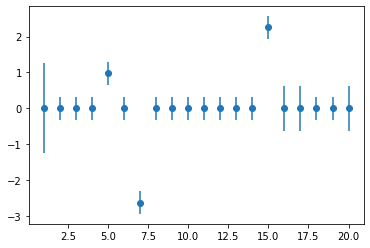

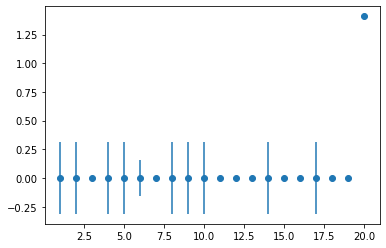

[[2 3 2 1 1]
 [4 0 0 0 1]
 [2 3 2 1 1]]
[2.1411961275738394, 2.3966666666666665, 2.253657950724053]
[[4 2 2 2 4]
 [0 4 4 2 1]
 [3 4 3 3 0]]
[3.0999999999999934, 3.6500000000000057, 1.4093318663732888]


In [3]:
print("THE BEST ARM FOR EXPERIMENT TOTAL IS:",
      arms[best_arm_index], "INDEX", best_arm_index)
print("THE BEST ARM FOR EXPERIMENT ONLY FIRST IS:",
      arms[best_arm_index2], "INDEX", best_arm_index2)

array = [i+1 for i in range(0, 20)]


plt.figure(1)
plt.errorbar(array, expected_values, yerr=(1/ts_learner.tau0), fmt='o')
plt.figure(0)
plt.errorbar(array, expected_values2, yerr=(1/ts_learner2.tau0), fmt='o')

plt.show()
print(np.array(arms)[clairvoyants])
print(clair_ex)
print(np.array(arms)[clairvoyants2])
print(clair_ex2)


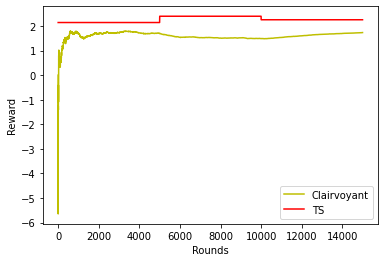

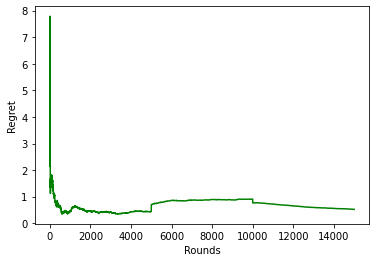

In [4]:
best_values = []
j = 0
k = 0
for i in range(n_experiments):
    k += 1
    best_values.append(clair_ex[j])
    if k == sw_size:
        k = 0
        j += 1

regret_no_qualities = [
    best_values[x] - thing_to_plot[x] for x in range(len(thing_to_plot))]
plt.figure(0)
plt.plot(thing_to_plot, 'y')
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.plot(best_values, 'r')
plt.legend(["Clairvoyant", "TS"])

plt.figure(1)
plt.ylabel("Regret")
plt.xlabel("Rounds")
plt.plot(regret_no_qualities, 'g')


Here are reward and regret for the case without ad qualities, with only ads in first position


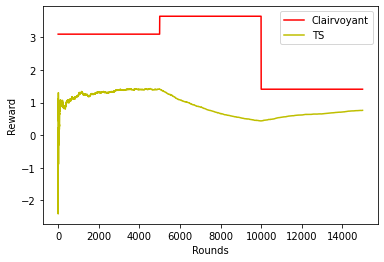

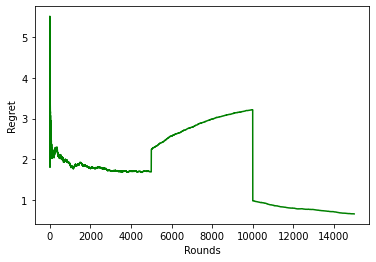

In [5]:
print("Here are reward and regret for the case without ad qualities, with only ads in first position")
best_values2 = []
j = 0
k = 0
for i in range(n_experiments):
    k += 1
    best_values2.append(clair_ex2[j])
    if k == sw_size:
        k = 0
        j += 1

regret_no_qualities2 = [
    best_values2[x] - thing_to_plot2[x] for x in range(len(thing_to_plot2))]
plt.figure(0)
plt.plot(best_values2, 'r')
plt.plot(thing_to_plot2, 'y')
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.legend(["Clairvoyant", "TS"])

plt.figure(1)
plt.ylabel("Regret")
plt.xlabel("Rounds")
plt.plot(regret_no_qualities2, 'g')
